## Imports

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

pd.set_option('display.max_columns', None)

## Read Train/Test Files

In [2]:
train_df = pd.read_parquet('../data/train_df.parquet')
test_df = pd.read_parquet('../data/test_df.parquet')

In [3]:
train_df.dtypes

transaction_id                 int64
tx_datetime           datetime64[ns]
customer_id                    int64
terminal_id                    int64
tx_amount                    float64
tx_time_seconds                int64
tx_time_days                   int64
tx_fraud                       int64
tx_date                       object
x_customer_id                float64
y_customer_id                float64
mean_nb_tx_per_day           float64
x_terminal_id                float64
y_terminal_id                float64
dtype: object

In [4]:
train_df.shape

(1403324, 14)

## Feature Engineering

Variáveis que serão criadas:

- **tx_hour**: Datetime em horas
- **tx_weekday**: Dia da semana baseado no datetime
- **tx_period_day**: Periodo do dia, se é manhã, tarde, noite ou madrugada
- **time_since_last_tx**: Tempo desde a última transação do cliente
- **nb_tx_last_1/7/30**: Contagem do número de transações na janela de tempo
- **avg_amount_last_1/7/30**: Média do valor das transações na janela de tempo
- **std_amount_last_1/7/30**: Desvio padrão do valor das transações na janela de tempo
- **tx_amount_median_ratio**: Mede a relação entre o valor da transação atual e a mediana dos valores das transações do mesmo cliente, ajudando a identificar desvios no padrão de gastos.
- **tx_amount_variation**: Variação percentual dos valores das transações consecutivas de um mesmo cliente, indicando possíveis mudanças abruptas nos gastos.
- **nb_tx_hour**: Número de transações realizadas por um cliente dentro de uma mesma hora, auxiliando na detecção de comportamentos incomuns, como um grande volume de transações em pouco tempo.
- **tx_amount_hour_mean**: Média dos valores das transações de um cliente em uma determinada hora, permitindo identificar se a transação atual está dentro do padrão usual de gastos do usuário.
- **mean_time_between_txs**: Tempo médio entre transações por cliente
- **std_time_between_txs**: Desvio padrão do tempo entre transações
- **tx_day**: Datetime em dias
- **tx_month**: Datetime em mês
- **mean_amount**: Média das transações
- **std_amount**: Desvio padrão das transações
- **distance_from_customer**: Distância entre a localização do cliente e a média das transações
- **is_single_tx_customer**: Clientes que realizou apenas uma única transação no histórico de dados. 
- **tx_amount_to_mean_ration**: Relação entre o valor da transação e a média da transação do cliente
- **repeated_tx**: Se há transações repetidas
- **outlier_tx**: Número de transações atípicas do cliente
- **unusual_hour**: Transações em horários incomum (antes das 6 e depois das 22)
- **frequent_tx**: Se há muitas transações em um curto período de tempo
- **high_value_tx**: Transações muito maiores que a média do cliente
- **amount_zscore_7d**: Mede o quão distante o valor da transação atual está da média dos últimos 7 dias
- **amount_zscore_30d**: Mede o quão distante o valor da transação atual está da média dos últimos 30 dias

In [5]:
def time_features(df):
    # Ordenar os dados por cliente e data para cálculo de diferenças de tempo
    df = df.sort_values(by=["customer_id", "tx_datetime"])

    # Criar feature de tempo desde a última transação do cliente
    df["time_since_last_tx"] = df.groupby("customer_id")["tx_datetime"].diff().dt.total_seconds()
    
    df["tx_hour"] = df["tx_datetime"].dt.hour
    df["weekday_of_day"] = df["tx_datetime"].dt.weekday
    df['month'] = df['tx_datetime'].dt.month
    df['year'] = df['tx_datetime'].dt.year
    df['is_weekend'] = df['tx_datetime'].dt.dayofweek >= 5
    df['month_reference'] = df['tx_datetime'].dt.strftime('%Y%m')

    df["tx_day"] = df["tx_datetime"].dt.day
    df["tx_month"] = df["tx_datetime"].dt.month
    
    # categoria por horario do dia
    df["tx_period_day"] = pd.cut(
        df["tx_hour"],
        bins=[0, 6, 12, 18, 24],
        labels=["madrugada", "manhã", "tarde", "noite"],
        right=False,
    )
    
    return df

def haversine(lon1,lat1,lon2,lat2):
    # convertes de graus para radianos
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # formula de haversine
    a = math.sin(delta_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    raio_terra = 6371.0

    distancia = raio_terra * c
    return distancia

def add_geodistance(df):
    df['distance_customer_terminal'] = df.apply(
        lambda row: haversine(row['x_customer_id'], row['y_customer_id'], row['x_terminal_id'], row['y_terminal_id']),
        axis=1
    )
    return df
    
def add_tx_variation(df):
    """Adiciona a variação percentual de valor das transações."""
    df["tx_amount_variation"] = df.groupby("customer_id")["tx_amount"].transform(lambda x: x.pct_change().fillna(0))
    return df

In [6]:
def feature_engineering(df):
    import time
    start_time = time.time()

    def time_features(df):
        # Ordenar os dados por cliente e data para cálculo de diferenças de tempo
        df = df.sort_values(by=["customer_id", "tx_datetime"])
    
        # Criar feature de tempo desde a última transação do cliente
        df["time_since_last_tx"] = df.groupby("customer_id")["tx_datetime"].diff().dt.total_seconds()
        
        df["tx_hour"] = df["tx_datetime"].dt.hour
        df["weekday_of_day"] = df["tx_datetime"].dt.weekday
        df['month'] = df['tx_datetime'].dt.month
        df['year'] = df['tx_datetime'].dt.year
        df['is_weekend'] = df['tx_datetime'].dt.dayofweek >= 5
        df['month_reference'] = df['tx_datetime'].dt.strftime('%Y%m')

        df["tx_day"] = df["tx_datetime"].dt.day
        df["tx_month"] = df["tx_datetime"].dt.month
        
        # categoria por horario do dia
        df["tx_period_day"] = pd.cut(
            df["tx_hour"],
            bins=[0, 6, 12, 18, 24],
            labels=["madrugada", "manhã", "tarde", "noite"],
            right=False,
        )
        
        return df

    def haversine(lon1,lat1,lon2,lat2):
        # convertes de graus para radianos
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)

        delta_lat = lat2_rad - lat1_rad
        delta_lon = lon2_rad - lon1_rad

        # formula de haversine
        a = math.sin(delta_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

        raio_terra = 6371.0

        distancia = raio_terra * c
        return distancia

    def add_geodistance(df):
        df['distance_customer_terminal'] = df.apply(
            lambda row: haversine(row['x_customer_id'], row['y_customer_id'], row['x_terminal_id'], row['y_terminal_id']),
            axis=1
        )
        return df

    def add_behavioral_flags(df):
        """Cria flags binárias de comportamento atípico ou padrão."""
        df["is_single_tx_customer"] = df.groupby("customer_id")["transaction_id"].transform("count") == 1
        df["repeated_tx"] = df.duplicated(subset=["customer_id", "tx_amount"], keep=False)
        df["outlier_tx"] = np.abs(df["tx_amount"] - df["mean_amount"]) > (2 * df["std_amount"])
        df["high_value_tx"] = df["tx_amount"] > (3 * df["mean_amount"])
        df["unusual_hour"] = (df["tx_hour"] < 6) | (df["tx_hour"] > 22)
        df["frequent_tx"] = df["time_since_last_tx"] < 60  # em segundos?
        df['consecutive_transactions_same_terminal'] = df['terminal_id'] == df.groupby('customer_id')['terminal_id'].shift(1)
        return df

    def aggregate_features(df):
        df = df.sort_values(by=["customer_id", "tx_datetime"])
        window_sizes = ['1h', '2h', '4h', '8h', '12h', '24h']
        
        results = []
        for cust_id, group in df.groupby("customer_id"):
            group = group.sort_values("tx_datetime").copy()
            group.set_index("tx_datetime", inplace=True)
    
            for window in window_sizes:
                # Todas as métricas de uma vez
                rolled = (
                    group[["tx_amount"]]
                    .rolling(window=window, min_periods=1)
                    .agg({
                        "tx_amount": ["count", "sum", "mean", "std", "median", "max"]
                    })
                )
    
                # Corrige nome das colunas multiindex
                rolled.columns = [f"{stat}_amount_per_customer_last_{window}" for stat in ["count", "total", "mean", "std", "median", "max"]]
    
                group = pd.concat([group, rolled], axis=1)
    
                # z-score
                group[f'std_amount_per_customer_last_{window}'] = group[f'std_amount_per_customer_last_{window}'].replace(0, 1e-6)
                group[f'amount_zscore_per_customer_last_{window}'] = (
                    (group["tx_amount"] - group[f'mean_amount_per_customer_last_{window}']) / group[f'std_amount_per_customer_last_{window}']
                )
    
            group.reset_index(inplace=True)
            results.append(group)
    
        df = pd.concat(results, ignore_index=True)
    
        # Calcular os ratios entre janelas (fora do loop por cliente para evitar recalcular a cada grupo)
        for window in window_sizes[1:]:  # começa do segundo item (p/ comparar com 1h)
            df[f'ratio_mean_amount_per_customer_last_1h_to_{window}'] = (
                df['mean_amount_per_customer_last_1h'] / df[f'mean_amount_per_customer_last_{window}']
            )
            df[f'ratio_total_transactions_per_customer_last_1h_to_{window}'] = (
                df['count_amount_per_customer_last_1h'] / df[f'count_amount_per_customer_last_{window}']
            )

        return df
    
    def add_value_statistics(df):
        """Cria estatísticas por cliente e razões com o valor atual."""
        df["mean_amount"] = df.groupby("customer_id")["tx_amount"].transform("mean")
        df["std_amount"] = df.groupby("customer_id")["tx_amount"].transform("std")
        df["tx_amount_median_ratio"] = df["tx_amount"] / df.groupby("customer_id")["tx_amount"].transform("median")
        df["tx_amount_to_mean_ration"] = df["tx_amount"] / df["mean_amount"]
        return df

    def add_hourly_patterns(df):
        """Adiciona padrões por hora do dia para cada cliente."""
        df["nb_tx_hour"] = df.groupby(["customer_id", "tx_hour"])["tx_amount"].transform("count")
        df["tx_amount_hour_mean"] = df.groupby(["customer_id", "tx_hour"])["tx_amount"].transform("mean")
        return df

    def add_time_between_txs_stats(df):
        """Adiciona estatísticas do tempo entre transações (assume que time_since_last_tx já foi criado)."""
        df["mean_time_between_txs"] = df.groupby("customer_id")["time_since_last_tx"].transform("mean")
        df["std_time_between_txs"] = df.groupby("customer_id")["time_since_last_tx"].transform("std")
        return df

    def add_tx_variation(df):
        """Adiciona a variação percentual de valor das transações."""
        df["tx_amount_variation"] = df.groupby("customer_id")["tx_amount"].transform(lambda x: x.pct_change().fillna(0))
        return df

    df = add_geodistance(df)
    df = aggregate_features(df)
    df = time_features(df)
    df = add_value_statistics(df)
    df = add_hourly_patterns(df)
    df = add_time_between_txs_stats(df)
    df = add_tx_variation(df)
    df = add_behavioral_flags(df)

    end_time = time.time()
    print(f"Tempo de execução: {end_time - start_time:.2f} segundos")
    return df

In [7]:
def compute_reference_stats(train_df):
    reference_stats = {}
    reference_stats["mean_amount_per_customer"] = train_df.groupby("customer_id")["tx_amount"].mean()
    reference_stats["std_amount_per_customer"] = train_df.groupby("customer_id")["tx_amount"].std().replace(0, 1e-6)
    reference_stats["median_amount_per_customer"] = train_df.groupby("customer_id")["tx_amount"].median()
    train_df["tx_hour"] = train_df["tx_datetime"].dt.hour
    ref_hour_group = train_df.groupby(["customer_id", "tx_hour"])["tx_amount"]
    reference_stats["count_tx_per_hour"] = ref_hour_group.count()
    reference_stats["mean_tx_amount_per_hour"] = ref_hour_group.mean()
    train_df = train_df.sort_values(by=["customer_id", "tx_datetime"])
    train_df["time_since_last_tx"] = train_df.groupby("customer_id")["tx_datetime"].diff().dt.total_seconds()
    reference_stats["mean_time_between_txs"] = train_df.groupby("customer_id")["time_since_last_tx"].mean()
    reference_stats["std_time_between_txs"] = train_df.groupby("customer_id")["time_since_last_tx"].std().replace(0, 1e-6)
    return reference_stats

In [8]:
def apply_reference_stats(df, reference_stats):
    df = df.copy()

    if "tx_hour" not in df.columns:
        df["tx_hour"] = df["tx_datetime"].dt.hour

    # Mapear estatísticas por cliente
    df["mean_amount"] = df["customer_id"].map(reference_stats["mean_amount_per_customer"])
    df["std_amount"] = df["customer_id"].map(reference_stats["std_amount_per_customer"])
    df["median_amount"] = df["customer_id"].map(reference_stats["median_amount_per_customer"])

    # Features derivadas
    df["tx_amount_to_mean_ration"] = df["tx_amount"] / df["mean_amount"]
    df["tx_amount_median_ratio"] = df["tx_amount"] / df["median_amount"]
    df["outlier_tx"] = np.abs(df["tx_amount"] - df["mean_amount"]) > (2 * df["std_amount"])
    df["high_value_tx"] = df["tx_amount"] > (3 * df["mean_amount"])
    df = df.drop(columns=['median_amount'],axis=1)
    # Padrões por hora
    df["nb_tx_hour"] = df.set_index(["customer_id", "tx_hour"]).index.map(reference_stats["count_tx_per_hour"])
    df["tx_amount_hour_mean"] = df.set_index(["customer_id", "tx_hour"]).index.map(reference_stats["mean_tx_amount_per_hour"])

    # Mapear tempos médios e std
    df["mean_time_between_txs"] = df["customer_id"].map(reference_stats["mean_time_between_txs"])
    df["std_time_between_txs"] = df["customer_id"].map(reference_stats["std_time_between_txs"])
    

    return df

In [9]:
def apply_historical_features(train_df, test_df):
    train_df = train_df.copy()
    test_df = test_df.copy()

    train_df["is_test"] = False
    test_df["is_test"] = True

    full_df = pd.concat([train_df, test_df], ignore_index=True)
    full_df = full_df.sort_values(by=["customer_id", "tx_datetime"])

    # ===============================================================
    # 1. FLAGS COMPORTAMENTAIS COM HISTÓRICO
    # ===============================================================

    
    full_df["is_single_tx_customer"] = full_df.groupby("customer_id")["transaction_id"].transform("count") == 1
    full_df["repeated_tx"] = full_df["repeated_tx"].fillna(
        full_df.duplicated(subset=["customer_id", "tx_amount"], keep=False)
    )
    full_df["consecutive_transactions_same_terminal"] = full_df["consecutive_transactions_same_terminal"].fillna(
        full_df["terminal_id"] == full_df.groupby("customer_id")["terminal_id"].shift(1)
    )

    # Verifica se colunas necessárias já existem

    full_df["tx_hour"] = full_df["tx_datetime"].dt.hour
    
    full_df["outlier_tx"] = full_df["outlier_tx"].fillna(
            np.abs(full_df["tx_amount"] - full_df["mean_amount"]) > (2 * full_df["std_amount"])
        )
    full_df["high_value_tx"] = full_df["high_value_tx"].fillna(
            full_df["tx_amount"] > (3 * full_df["mean_amount"])
        )
    
    # time_since_last_tx — só preenche onde estiver faltando
    full_df["time_since_last_tx"] = full_df["time_since_last_tx"].fillna(
        full_df.groupby("customer_id")["tx_datetime"].diff().dt.total_seconds()
    )

    full_df["frequent_tx"] = full_df["frequent_tx"].fillna(full_df["time_since_last_tx"] < 60)
    full_df["unusual_hour"] = (full_df["tx_hour"] < 6) | (full_df["tx_hour"] > 22)

    # ===============================================================
    # 2. ROLLING WINDOWS COM HISTÓRICO
    # ===============================================================

    window_sizes = ['1h', '2h', '4h', '8h', '12h', '24h']
    results = []

    for cust_id, group in full_df.groupby("customer_id"):
        group = group.sort_values("tx_datetime").copy()
        group.set_index("tx_datetime", inplace=True)

        for window in window_sizes:
            rolled = (
                group[["tx_amount"]]
                .rolling(window=window, min_periods=1)
                .agg({
                    "tx_amount": ["count", "sum", "mean", "std", "median", "max"]
                })
            )
            rolled.columns = [
            f"{stat}_amount_per_customer_last_{window}" 
            for stat in ["count", "total", "mean", "std", "median", "max"]
        ]
            for col in rolled.columns:
                group[col] = rolled[col].values

            std_col = f'std_amount_per_customer_last_{window}'
            mean_col = f'mean_amount_per_customer_last_{window}'
            z_col = f'amount_zscore_per_customer_last_{window}'

            # Substitui std = 0 por valor mínimo para evitar divisão por zero
            std_values = group[std_col].replace(0, 1e-6).values
            mean_values = group[mean_col].values

            group[z_col] = (group["tx_amount"].values - mean_values) / std_values

        group.reset_index(inplace=True)
        results.append(group)

    full_df = pd.concat(results, ignore_index=True)

    # Ratios entre janelas
    for window in window_sizes[1:]:
        full_df[f'ratio_mean_amount_per_customer_last_1h_to_{window}'] = (
            full_df['mean_amount_per_customer_last_1h'] / full_df[f'mean_amount_per_customer_last_{window}']
        )
        full_df[f'ratio_total_transactions_per_customer_last_1h_to_{window}'] = (
            full_df['count_amount_per_customer_last_1h'] / full_df[f'count_amount_per_customer_last_{window}']
        )

    # Separar test_df com histórico aplicado
    test_df_final = full_df[full_df["is_test"]].drop(columns=["is_test"])
    return test_df_final

In [10]:
train_df = feature_engineering(train_df)

Tempo de execução: 348.44 segundos


In [11]:
reference_stats = compute_reference_stats(train_df)
test_df = apply_reference_stats(test_df, reference_stats)
test_df = apply_historical_features(train_df, test_df)
test_df = time_features(test_df)
test_df = add_geodistance(test_df)
test_df = add_tx_variation(test_df)

C:\Users\caiom\AppData\Local\Temp\ipykernel_10768\1443477563.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_df["repeated_tx"] = full_df["repeated_tx"].fillna(
C:\Users\caiom\AppData\Local\Temp\ipykernel_10768\1443477563.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_df["consecutive_transactions_same_terminal"] = full_df["consecutive_transactions_same_terminal"].fillna(
C:\Users\caiom\AppData\Local\Temp\ipykernel_10768\1443477563.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will c

In [12]:
int32_cols = train_df.select_dtypes(include=['int32']).columns
train_df[int32_cols] = train_df[int32_cols].astype(np.int64)

In [13]:
pd.set_option('display.max_rows', None)
df_types = pd.DataFrame({
    "column": train_df.columns,
    "dtype": train_df.dtypes.values
})
display(df_types)

,column,dtype
0,tx_datetime,datetime64[ns]
1,transaction_id,int64
2,customer_id,int64
3,terminal_id,int64
4,tx_amount,float64
5,tx_time_seconds,int64
6,tx_time_days,int64
7,tx_fraud,int64
8,tx_date,object
9,x_customer_id,float64


# Tratando dados nulos

In [14]:
test_df.sample()

,tx_datetime,transaction_id,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_date,x_customer_id,y_customer_id,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,distance_customer_terminal,count_amount_per_customer_last_1h,total_amount_per_customer_last_1h,mean_amount_per_customer_last_1h,std_amount_per_customer_last_1h,median_amount_per_customer_last_1h,max_amount_per_customer_last_1h,amount_zscore_per_customer_last_1h,count_amount_per_customer_last_2h,total_amount_per_customer_last_2h,mean_amount_per_customer_last_2h,std_amount_per_customer_last_2h,median_amount_per_customer_last_2h,max_amount_per_customer_last_2h,amount_zscore_per_customer_last_2h,count_amount_per_customer_last_4h,total_amount_per_customer_last_4h,mean_amount_per_customer_last_4h,std_amount_per_customer_last_4h,median_amount_per_customer_last_4h,max_amount_per_customer_last_4h,amount_zscore_per_customer_last_4h,count_amount_per_customer_last_8h,total_amount_per_customer_last_8h,mean_amount_per_customer_last_8h,std_amount_per_customer_last_8h,median_amount_per_customer_last_8h,max_amount_per_customer_last_8h,amount_zscore_per_customer_last_8h,count_amount_per_customer_last_12h,total_amount_per_customer_last_12h,mean_amount_per_customer_last_12h,std_amount_per_customer_last_12h,median_amount_per_customer_last_12h,max_amount_per_customer_last_12h,amount_zscore_per_customer_last_12h,count_amount_per_customer_last_24h,total_amount_per_customer_last_24h,mean_amount_per_customer_last_24h,std_amount_per_customer_last_24h,median_amount_per_customer_last_24h,max_amount_per_customer_last_24h,amount_zscore_per_customer_last_24h,ratio_mean_amount_per_customer_last_1h_to_2h,ratio_total_transactions_per_customer_last_1h_to_2h,ratio_mean_amount_per_customer_last_1h_to_4h,ratio_total_transactions_per_customer_last_1h_to_4h,ratio_mean_amount_per_customer_last_1h_to_8h,ratio_total_transactions_per_customer_last_1h_to_8h,ratio_mean_amount_per_customer_last_1h_to_12h,ratio_total_transactions_per_customer_last_1h_to_12h,ratio_mean_amount_per_customer_last_1h_to_24h,ratio_total_transactions_per_customer_last_1h_to_24h,time_since_last_tx,tx_hour,weekday_of_day,month,year,is_weekend,month_reference,tx_day,tx_month,tx_period_day,mean_amount,std_amount,tx_amount_median_ratio,tx_amount_to_mean_ration,nb_tx_hour,tx_amount_hour_mean,mean_time_between_txs,std_time_between_txs,tx_amount_variation,is_single_tx_customer,repeated_tx,outlier_tx,high_value_tx,unusual_hour,frequent_tx,consecutive_transactions_same_terminal
1282455,2018-09-23 12:31:51,1683001,3664,4409,45.22,15165111,175,0,2018-09-23,67.324554,79.339088,1.122277,68.594353,78.721762,73.710301,1.0,45.22,45.22,NaN,45.22,45.22,NaN,1.0,45.22,45.22,NaN,45.22,45.22,NaN,2.0,114.96,57.48,17.338258,57.48,69.74,-0.707107,3.0,119.97,39.99,32.68039,45.22,69.74,0.160035,3.0,119.97,39.99,32.68039,45.22,69.74,0.160035,3.0,119.97,39.99,32.68039,45.22,69.74,0.160035,1.0,1.0,0.786708,0.5,1.130783,0.333333,1.130783,0.333333,1.130783,0.333333,9473.0,12,6,9,2018,True,201809,23,9,tarde,52.094354,23.596941,0.864131,0.86804,11.0,49.900909,85893.541096,79166.35271,-0.351592,False,False,False,False,False,False,False


In [15]:
test_df.isna().sum()

tx_datetime                                                  0
transaction_id                                               0
customer_id                                                  0
terminal_id                                                  0
tx_amount                                                    0
tx_time_seconds                                              0
tx_time_days                                                 0
tx_fraud                                                     0
tx_date                                                      0
x_customer_id                                                0
y_customer_id                                                0
mean_nb_tx_per_day                                           0
x_terminal_id                                                0
y_terminal_id                                                0
distance_customer_terminal                                   0
count_amount_per_customer_last_1h                      

In [16]:
test_df.isna().sum()

tx_datetime                                                  0
transaction_id                                               0
customer_id                                                  0
terminal_id                                                  0
tx_amount                                                    0
tx_time_seconds                                              0
tx_time_days                                                 0
tx_fraud                                                     0
tx_date                                                      0
x_customer_id                                                0
y_customer_id                                                0
mean_nb_tx_per_day                                           0
x_terminal_id                                                0
y_terminal_id                                                0
distance_customer_terminal                                   0
count_amount_per_customer_last_1h                      

In [17]:
def treat_missing_values(df):
    # -------------------------
    # Valores globais auxiliares
    # -------------------------
    median_amount_global = df["tx_amount"].median()
    
    # -------------------------
    # Rolling stats
    # -------------------------
    std_cols = [col for col in df.columns if col.startswith("std_amount_per_customer_last_")]
    df[std_cols] = df[std_cols].fillna(1e-6)

    # Substitui zscore por 0 (neutro)
    zscore_cols = [col for col in df.columns if col.startswith("amount_zscore_per_customer_last_")]
    df[zscore_cols] = df[zscore_cols].fillna(0)

    # -------------------------
    # Tempo entre transações
    # -------------------------
    if 'time_since_last_tx' in df.columns:
        df["time_since_last_tx"] = df["time_since_last_tx"].fillna(df["time_since_last_tx"].max())

    if 'mean_time_between_txs' in df.columns:
        df["mean_time_between_txs"] = df["mean_time_between_txs"].fillna(df["mean_time_between_txs"].median())

    if 'std_time_between_txs' in df.columns:
        df["std_time_between_txs"] = df["std_time_between_txs"].fillna(df["std_time_between_txs"].median())

    # -------------------------
    # Média e desvio padrão por cliente
    # -------------------------
    if 'std_amount' in df.columns:
        df["std_amount"] = df["std_amount"].fillna(1e-6)

    if 'mean_amount' in df.columns:
        df["mean_amount"] = df["mean_amount"].fillna(df["mean_amount"].median())
        
    if 'tx_amount_to_mean_ration' in df.columns:
        df["tx_amount_to_mean_ration"] = df["tx_amount_to_mean_ration"].fillna(
            df["tx_amount"] / df["mean_amount"]
        )

    median_amount_global = df["tx_amount"].median()
    if 'tx_amount_median_ratio' in df.columns:
        df["tx_amount_median_ratio"] = df["tx_amount_median_ratio"].fillna(
            df["tx_amount"] / median_amount_global
        )
        
    # -------------------------
    # Razões entre janelas
    # -------------------------
    ratio_cols = [col for col in df.columns if col.startswith("ratio_mean_amount_per_customer_last_1h_to_")]
    df[ratio_cols] = df[ratio_cols].fillna(1.0)

    # -------------------------
    # Padrões por hora do dia
    # -------------------------
    if "nb_tx_hour" in df.columns and "tx_hour" in df.columns:
        fallback_count = df.groupby("tx_hour")["nb_tx_hour"].median()
        df["nb_tx_hour"] = df.apply(
            lambda row: fallback_count[row["tx_hour"]] if pd.isna(row["nb_tx_hour"]) else row["nb_tx_hour"],
            axis=1
        )

    if "tx_amount_hour_mean" in df.columns and "tx_hour" in df.columns:
        fallback_mean = df.groupby("tx_hour")["tx_amount_hour_mean"].median()
        df["tx_amount_hour_mean"] = df.apply(
            lambda row: fallback_mean[row["tx_hour"]] if pd.isna(row["tx_amount_hour_mean"]) else row["tx_amount_hour_mean"],
            axis=1
        )
        
    # -------------------------
    # tx_amount_variation (evita infinitos por divisão por zero)
    # -------------------------
    if "tx_amount_variation" in df.columns:
        df["tx_amount_variation"] = df["tx_amount_variation"].replace([np.inf, -np.inf], np.nan)
        df["tx_amount_variation"] = df["tx_amount_variation"].fillna(0.0)
        
    return df

In [18]:
train_df = treat_missing_values(train_df)
test_df = treat_missing_values(test_df)

In [19]:
test_df.isna().sum()

tx_datetime                                             0
transaction_id                                          0
customer_id                                             0
terminal_id                                             0
tx_amount                                               0
tx_time_seconds                                         0
tx_time_days                                            0
tx_fraud                                                0
tx_date                                                 0
x_customer_id                                           0
y_customer_id                                           0
mean_nb_tx_per_day                                      0
x_terminal_id                                           0
y_terminal_id                                           0
distance_customer_terminal                              0
count_amount_per_customer_last_1h                       0
total_amount_per_customer_last_1h                       0
mean_amount_pe

## Definindo quais colunas serão utilizadas

In [20]:
cols_to_drop = ['transaction_id', 'tx_datetime', 'customer_id', 'terminal_id', 'tx_date',
                'x_customer_id', 'y_customer_id', 'x_terminal_id',
                'y_terminal_id', 'month_reference', 'tx_month']

train_df = train_df.drop(columns = cols_to_drop, axis=1)
test_df = test_df.drop(columns = cols_to_drop, axis=1)

## Tratando dados categoricos

In [21]:
def convert_categorical_data(df):
    import time
    start_time = time.time()
    
    freq_encoding = df["tx_period_day"].value_counts(normalize=True).to_dict()
    df["tx_period_day_fe"] = df["tx_period_day"].map(freq_encoding)
    df.drop(columns=["tx_period_day"], inplace=True)

    end_time = time.time()
    print(f"Tempo de execução: {end_time - start_time:.2f} segundos")
    return df

In [22]:
train_df = convert_categorical_data(train_df)
test_df = convert_categorical_data(test_df)

Tempo de execução: 0.62 segundos
Tempo de execução: 0.20 segundos


In [23]:
train_df.shape

(1403324, 82)

In [24]:
pd.set_option('display.max_rows', None)
df_types = pd.DataFrame({
    "column": train_df.columns,
    "dtype": train_df.dtypes.values
})
display(df_types)

,column,dtype
0,tx_amount,float64
1,tx_time_seconds,int64
2,tx_time_days,int64
3,tx_fraud,int64
4,mean_nb_tx_per_day,float64
5,distance_customer_terminal,float64
6,count_amount_per_customer_last_1h,float64
7,total_amount_per_customer_last_1h,float64
8,mean_amount_per_customer_last_1h,float64
9,std_amount_per_customer_last_1h,float64


## Treinando Modelo

### tratando dados de teste

### Separando em treino e teste

In [25]:
X_train, y_train = train_df.drop(columns=["tx_fraud"]), train_df["tx_fraud"]
X_test, y_test = test_df.drop(columns=["tx_fraud"]), test_df["tx_fraud"]

### Modelos

In [26]:
rf_model_desbalanceada = RandomForestClassifier(
                    n_estimators=200,       # Número de árvores
                    max_depth=7,            # Controle de profundidade (complexidade)
                    min_samples_split=15,   # Evita splits com poucos exemplos
                    min_samples_leaf=7,     # Evita folhas muito pequenas
                    max_features='sqrt',    # Aumenta diversidade das árvores
                    bootstrap=True,         # Mantém aleatoriedade na amostragem
                    random_state=42,
                    n_jobs=-1               # Usa todos os processadores disponíveis
                )
rf_model_desbalanceada.fit(X_train, y_train)

rf_model = RandomForestClassifier(
                    n_estimators=200,
                    max_depth=7,
                    min_samples_split=15,
                    min_samples_leaf=7,
                    max_features='sqrt',
                    class_weight='balanced_subsample',
                    bootstrap=True,
                    random_state=42,
                    n_jobs=-1
                )
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(
                    n_estimators=200,         # Número de árvores
                    max_depth=4,              # Controle de profundidade (complexidade)
                    learning_rate=0.05,       # Aprendizado mais suave
                    colsample_bytree=0.8,     # Mantém diversidade das features
                    scale_pos_weight=3,       # Balanceamento da classe fraudulenta
                    min_child_weight=10,      # Evita splits fracos
                    gamma=5,                  # Penaliza splits irrelevantes
                    subsample=0.7,            # Evita overfitting ao limitar amostras por árvore
                    reg_lambda=10,            # Regularização L2 para reduzir overfit
                    random_state=42,
                    enable_categorical=True
                )
xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMClassifier(
                    n_estimators=200,
                    max_depth=4,
                    learning_rate=0.05,
                    colsample_bytree=0.8,
                    min_child_weight=5,  # Reduzindo de 10 para permitir mais divisões
                    reg_lambda=10,
                    subsample=0.7,
                    force_row_wise=True,
                    min_split_gain=0.01,  # Evita splits sem ganho real
                    scale_pos_weight=2.0,  # Ajuste para melhorar precisão
                    random_state=42,
                    verbose=-1
                )
lgb_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8, force_row_wise=True, learning_rate=0.05,
               max_depth=4, min_child_weight=5, min_split_gain=0.01,
               n_estimators=200, random_state=42, reg_lambda=10,
               scale_pos_weight=2.0, subsample=0.7, verbose=-1)

## Avaliação

In [27]:
def avaliar_multiplos_modelos(models, X_train, y_train, X_test, y_test, threshold=0.5):
    """
    Avalia múltiplos modelos de Machine Learning comparando desempenho em treino e teste.

    Parâmetros:
    - models: dicionário de modelos treinados { "Nome do Modelo": modelo_treinado }
    - X_train: features de treino
    - y_train: labels de treino
    - X_test: features de teste
    - y_test: labels de teste
    - threshold: valor limite para converter probabilidades em classes (default = 0.5)

    Retorna:
    - DataFrame com métricas de treino e teste para cada modelo
    - Exibe matrizes de confusão para cada modelo
    """

    results = []

    for name, model in models.items():
        print(f"\n=== Avaliando o Modelo: {name} ===")

        # Predições em treino e teste
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]

        y_train_pred = (y_train_proba >= threshold).astype(int)
        y_test_pred = (y_test_proba >= threshold).astype(int)

        # Cálculo das métricas
        train_auc = roc_auc_score(y_train, y_train_proba)
        train_precision = precision_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred)

        test_auc = roc_auc_score(y_test, y_test_proba)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        # Adiciona resultados ao DataFrame
        results.append([name, train_auc, test_auc, train_precision, test_precision, train_recall, test_recall, train_f1, test_f1])

    # Criar um DataFrame com os resultados
    df_results = pd.DataFrame(results, columns=[
        "Modelo", "AUC-ROC (Treino)", "AUC-ROC (Teste)", 
        "Precision (Treino)", "Precision (Teste)", 
        "Recall (Treino)", "Recall (Teste)", 
        "F1-Score (Treino)", "F1-Score (Teste)"
    ])
    
    return df_results

In [28]:
models = {
    "XGBoost": xgb_model,
    "LightGBM": lgb_model,
    "Random Forest": rf_model
}

df_resultados = avaliar_multiplos_modelos(models, X_train, y_train, X_test, y_test, threshold=0.4)


=== Avaliando o Modelo: XGBoost ===

=== Avaliando o Modelo: LightGBM ===

=== Avaliando o Modelo: Random Forest ===


In [29]:
df_resultados

,Modelo,AUC-ROC (Treino),AUC-ROC (Teste),Precision (Treino),Precision (Teste),Recall (Treino),Recall (Teste),F1-Score (Treino),F1-Score (Teste)
0,XGBoost,0.781363,0.669861,0.902970,0.893502,0.345417,0.314286,0.499686,0.465007
1,LightGBM,0.784721,0.671835,0.927601,0.925752,0.343335,0.312698,0.501171,0.467489
2,Random Forest,0.751372,0.664489,0.010159,0.009357,0.909808,0.912381,0.020095,0.018524


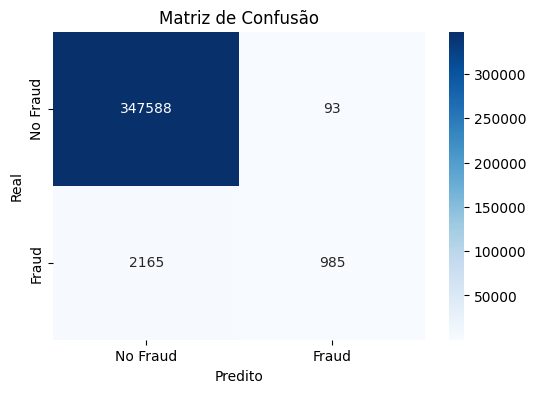

In [30]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

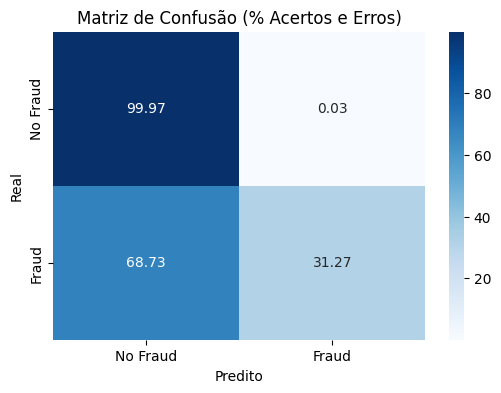

In [31]:
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão (% Acertos e Erros)")
plt.show()

Nosso modelo tem um excelente desempenho em evitar falsos positivos, ou seja, quase nenhuma transação legítima está sendo considerada como fraude (3%). Isso reduz o impacto para clientes legítmos. Por outro lado, o modelo tem uma taxa alta de falsos negativos (68.73%), ou seja, ele não detecta a maioria das fraudes. Apenas 31.27% das transações fraudulentas foram identificadas corretamente.

In [32]:
def gerar_classificacao(models, X_test, y_test, threshold=0.4):
    """
    Aplica os modelos treinados no conjunto de teste e retorna um DataFrame com a classificação correta.

    Parâmetros:
    - models: dicionário { "Nome do Modelo": modelo_instanciado }
    - X_test: features de teste
    - y_test: labels de teste
    - threshold: valor para converter probabilidades em classes (default=0.4)

    Retorna:
    - DataFrame com as previsões e a classificação correta (TP, FP, FN, TN).
    """

    results_df = X_test.copy()
    results_df["Real"] = y_test.values

    for name, model in models.items():
        # Fazer predição do modelo
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Criar colunas de predição para cada modelo
        results_df[f"Predito_{name}"] = y_pred

        # Definir classificações (TP, FP, FN, TN)
        conditions = [
            (results_df["Real"] == 0) & (results_df[f"Predito_{name}"] == 0),  # TN
            (results_df["Real"] == 0) & (results_df[f"Predito_{name}"] == 1),  # FP
            (results_df["Real"] == 1) & (results_df[f"Predito_{name}"] == 0),  # FN
            (results_df["Real"] == 1) & (results_df[f"Predito_{name}"] == 1)   # TP
        ]
        choices = ["TN", "FP", "FN", "TP"]

        # Adicionar coluna de classificação específica para cada modelo
        results_df[f"Classificação_{name}"] = np.select(conditions, choices, default="Erro")

    return results_df

In [33]:
def avaliar_perdas(models, results_df, test_df):
    """
    Calcula o impacto financeiro de fraudes detectadas e não detectadas para cada modelo.

    Parâmetros:
    - models: dicionário { "Nome do Modelo": modelo_instanciado }
    - results_df: DataFrame contendo as previsões e classificações de cada modelo.
    - test_df: DataFrame original de teste contendo 'tx_amount' e 'tx_fraud'.

    Retorna:
    - DataFrame consolidado com os valores financeiros perdidos por modelo.
    """

    # Total de transações e total de fraudes reais no conjunto de teste
    total_amount = test_df['tx_amount'].sum()
    total_amount_fraud = test_df[test_df['tx_fraud'] == 1]['tx_amount'].sum()

    # Baseline (quanto perderíamos sem modelo nenhum)
    baseline = float(total_amount_fraud)
    ciclo_01 = float(286230.30)
    results = []

    for name in models.keys():
        # Cálculo dos valores perdidos por classificação
        tp_tx_amount = results_df[results_df[f"Classificação_{name}"] == "TP"]['tx_amount'].sum()
        fn_tx_amount = results_df[results_df[f"Classificação_{name}"] == "FN"]['tx_amount'].sum()
        fp_tx_amount = results_df[results_df[f"Classificação_{name}"] == "FP"]['tx_amount'].sum()
        tn_tx_amount = results_df[results_df[f"Classificação_{name}"] == "TN"]['tx_amount'].sum()

        # Total de perdas devido a fraudes não detectadas (FN) e falsos positivos (FP)
        total_ciclo = fn_tx_amount + fp_tx_amount

        # Percentual de redução em relação ao baseline
        reducao_percentual = round((1 - (total_ciclo / baseline)) * 100, 2)

        # Adiciona ao resultado
        results.append([name, f"R$ {baseline:.2f}", f"R$ {ciclo_01:.2f}",f"R$ {total_ciclo:.2f}", f"{reducao_percentual}%"])

    # Criar DataFrame consolidado
    df_perdas = pd.DataFrame(results, columns=["Modelo", "Baseline (Perda Sem Modelo)", "Ciclo 01","Perda Total do Modelo no Ciclo Atual", "Redução % vs. Baseline"])

    return df_perdas

In [34]:
models = {
    "XGBoost": xgb_model,
    "LightGBM": lgb_model,
    "Random Forest": rf_model
}

df_classificacao = gerar_classificacao(models, X_test, y_test)

In [35]:
df_perdas = avaliar_perdas(models, df_classificacao, test_df)
df_perdas

,Modelo,Baseline (Perda Sem Modelo),Ciclo 01,Perda Total do Modelo no Ciclo Atual,Redução % vs. Baseline
0,XGBoost,R$ 411671.78,R$ 286230.30,R$ 138112.33,66.45%
1,LightGBM,R$ 411671.78,R$ 286230.30,R$ 131316.99,68.1%
2,Random Forest,R$ 411671.78,R$ 286230.30,R$ 16223572.59,-3840.9%


## Importância das Variáveis

In [36]:
feature_importance = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

In [37]:
importance_df[importance_df['Importance'] > 0.0040]['Feature'].to_list()

importance_list = ['tx_amount_median_ratio', 'tx_amount_to_mean_ration', 'max_amount_per_customer_last_12h', 'high_value_tx',
                   'max_amount_per_customer_last_8h', 'outlier_tx', 'max_amount_per_customer_last_24h', 'max_amount_per_customer_last_4h',
                   'std_amount', 'tx_time_days', 'tx_time_seconds', 'total_amount_per_customer_last_2h', 'max_amount_per_customer_last_1h',
                   'mean_amount', 'amount_zscore_per_customer_last_24h', 'std_amount_per_customer_last_24h', 'month', 'tx_amount_variation',
                   'tx_amount_hour_mean', 'median_amount_per_customer_last_4h', 'total_amount_per_customer_last_1h',
                   'mean_amount_per_customer_last_1h', 'amount_zscore_per_customer_last_1h', 'ratio_total_transactions_per_customer_last_1h_to_2h',
                   'mean_amount_per_customer_last_24h', 'ratio_mean_amount_per_customer_last_1h_to_24h', 'tx_amount']

## Conclusão

Tivemos uma melhora muito expressiva se comparado ao ciclo anterior, além de um modelo mais explicativo, que não depende de apenas uma variável e que será melhor generalizado. Ou seja, o nosso modelo funcionará melhor para mais casos de fraudes, o que o torna mais robusto. 

A feature importance nos mostra que temos algumas variáveis que podem ser desconsideradas.

## Próximos Passos

Coss-validation com Random Forest (Balanceada), XGBoost e LightGBM para definir qual dos modelos usar.
Vamos partir para uma crossvalidation e fine tuning do modelo utilizando grid search do melhor modelo na crossvalidation.

## Salvando dataframes

In [38]:
train_df.to_parquet('../data/train_cycle02.parquet', index=False)
test_df.to_parquet('../data/test_cycle02.parquet', index=False)